# Topic Deep Dive: Fisher's Exact Test

Fisher's Exact Test is one of the oldest statistical tests (actually, is it the oldest? Maybe?) and can also be used for one of the most common tests out there, which is a test of two proportions (performing a hypothesis test if two proportions are equal), although it isn't recommended because Fisher's Exact Test is only recommended for low sample sizes due to computational concerns. While some of the Basics series cover Fisher's Exact Test (lightly), this one will go a little deeper, focusing on the same level of depth as the [Wikipedia page](https://en.wikipedia.org/wiki/Fisher%27s_exact_test), but filling in the intuitive gaps that may be quite lacking when reading only the Wikipedia article.

## Contingency Table

The first sentence of the Wikipedia Entry is that Fisher's Exact Test is used for analyzing contingency tables, so it is worth discussing that first.

A contingency table is a table that displays the multivariate frequency distribution of the variables.

For example, say we sample 100 individuals from some population for a study and find out what their sex at assigned birth was: Male or Female, and if they are Right handed or left handed. Notice that there can be 4 different combinations of people then, which would be $MR, ML, FR, FL$. We could represent this information with the following table (a 2x2 contingency table):

| |Right-Handed|Left-Handed| Row Total |
|-|-|-|-|
|Male|43|9|52|
|Female|44|4|48|
|Column Total|87|13|100

From this data, we can see that out of the 100 people we sampled, 87% of them were right handed, and 52% of them were Male. We also see how 43% of people were Male *and* Right-handed. We can also ponder questions like, "Do left-handed people tend to be more male than female?" by comparing the *proportion* of right-handed people that are Male ($43/87\approx 0.49$) versus the *proportion* of left-handed people that are Male ($9/13\approx 0.69$). Of-course, the reason why we don't immediately say "Yes" even though the difference is apparent (0.69 vs 0.49) because we understand that what we're really asking for is a property of the population that we sampled from, and we also know that when sample size is not large, differences can just be due to chance, especially since in this case we see that we only have 13 total left-handed individuals.

It's also important to note that the Column Totals and Row Totals (the total number of males, the total number of females, total number of right-handed, the total number of left-handed) are referred to as the *margin* totals.

Assuming that we sampled the individuals randomly, we can perform hypothesis tests using tests such as a $\chi^2$ test, the $G$-test, Boschloo's test, Bernard's test as well as Fisher's Exact which precedes all the other ones and is also the primary topic of this notebook. If after we perform the test and the proportion varies significantly, then we say there is a *contingency* between right-handedness and gender, or in other words, right-handedness and gender are not independent.

## Hypergeometric Distribution

To measure if we have evidence that the two proportions vary significantly, we need a way to somehow understand the distribution of the sampled data. Fisher showed that we can calculate the $p$-value because how the data is arranged can be represented by a hypergeometric distribution.

To dig a little deeper, he showed that the following table,

| |Right-Handed|Left-Handed| Row Total |
|-|-|-|-|
|Male|a|b|a+b|
|Female|c|d|c+d|
|Column Total|a+c|b+d|a+b+c+d=n

when conditioning on the marginal totals, the distribution of $a,b,c,d$ has a hypergeometric distribution. Conditioning on the marginal means that we know what the totals are. So for example, We *know* that the total number of Left handed people are 13, which means that if we know that the # of people who are left handed *and* male are 9, we simply know by subtraction that the number of left handed *and* female must be 4. And with these properties, it has been shown that we can use this table as a proportions test.

The interesting property about this conditioning of marginals is that if we know just one of the 4 boxes, $a,b,c,d$, we actually know all (equivalent to saying that there is only 1 degree of freedom). So we can actually just say that $a$ is distributed as a hypergeometric distribution with $(a+c)$ draws from a population with $(a+b)$ successes and $(c+d)$ failures (proven by Fisher) and this should tell you everything about the arrangement of $a,b,c,d$ and thus the distribution of the two proportions which is our true metric of interest.

Also, the line *$a$ is distributed as a hypergeometric distribution with $(a+c)$ draws from a population with $(a+b)$ successes and $(c+d)$ failures* means that given the marginals, the probability of $a$ equals:

$${\displaystyle p(a)={\frac {\displaystyle {{a+b} \choose {a}}\displaystyle {{c+d} \choose {c}}}{\displaystyle {{n} \choose {a+c}}}}={\frac {\displaystyle {{a+b} \choose {b}}\displaystyle {{c+d} \choose {d}}}{\displaystyle {{n} \choose {b+d}}}}={\frac {(a+b)!~(c+d)!~(a+c)!~(b+d)!}{a!~~b!~~c!~~d!~~n!}}}$$

## Testing

To test the likelihood that the difference betwee $0.49$ and $0.69$ is more than just chance, we need to calculate the $p$-value. The $p$-value is defined as the probability of seeing your event or rarer. What this means for an Exact Test like Fisher's is that we need to calculate the probability of every value of $a$ and then sum the probabilities that are equal to or rarer than the probability of $a$ that you actually witnessed. We can see how $a$ can vary between $0$ and $52$, which means we'll have to calculate 53 different probabilities. We can first create a function for the hypergeometric distribution below

In [23]:
def hypergeo(a_val, draws, successes, failures):
  """
  Takes in (a+c) draws from a population with (a+b) successes and (c+d) failures and computes the probability of a given the marginals
  Parameters:
  - draws: a+c
  - successes: a+b
  - failures: c+d
  """
  # we need a system of equations to solve a,b,c,d given the 3 sums.
  # Set up the system of equations
  from sympy import symbols, Eq, solve

  # Define the variables
  a, b, c, d = symbols('a b c d')

  equations = [
    Eq(a + c, draws),
    Eq(a + b, successes),
    Eq(c + d, failures),
    Eq(a, a_val)
  ]

  # solve
  solution = solve(equations, (a, b, c, d))

  # Extract the values
  b_val = int(solution[b])
  c_val = int(solution[c])
  d_val = int(solution[d])

  from math import comb
  return (comb(a_val+b_val,a_val)*comb(c_val+d_val,c_val))/comb(a_val+b_val+c_val+d_val,a_val+c_val)

Now, we do this for all 0 - 52

Text(0, 0.5, 'probability')

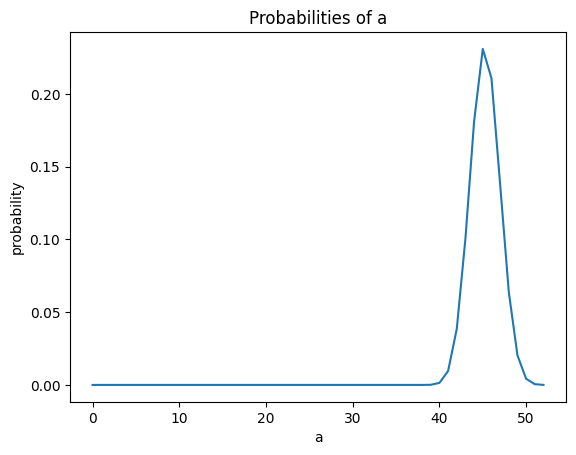

In [33]:
x_vals = list(range(53))
y_vals = []

for i in x_vals:
  y_vals.append(hypergeo(i,87,52,48))

import matplotlib.pyplot as plt
plt.plot(x_vals,y_vals)
plt.title('Probabilities of a'); plt.xlabel('a'); plt.ylabel('probability')

The probabilities are highest between $a$ values of 40 and 50. This is kind of hard to understand, so let's replace $a$ with the differences in proportion of right handed that are male vs proportion of female that are left handed.

For this, we'll need a function that converts $a$ to the difference in proportions:

In [37]:
def diffprop(a_val, draws, successes, failures):
  """
  Takes in (a+c) draws from a population with (a+b) successes and (c+d) failures and computes the difference in proportion
  Parameters:
  - draws: a+c
  - successes: a+b
  - failures: c+d
  """
  # we need a system of equations to solve a,b,c,d given the 3 sums.
  # Set up the system of equations
  from sympy import symbols, Eq, solve

  # Define the variables
  a, b, c, d = symbols('a b c d')

  equations = [
    Eq(a + c, draws),
    Eq(a + b, successes),
    Eq(c + d, failures),
    Eq(a, a_val)
  ]

  # solve
  solution = solve(equations, (a, b, c, d))

  # Extract the values
  b_val = int(solution[b])
  c_val = int(solution[c])
  d_val = int(solution[d])

  from math import comb
  return (a_val/(a_val+c_val) - b_val/(b_val+d_val))

Text(0, 0.5, 'probability')

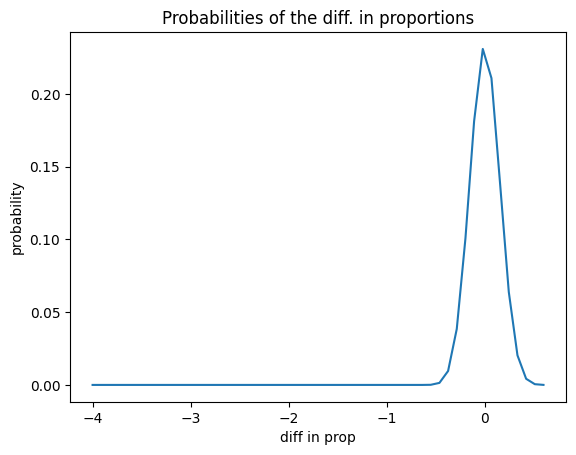

In [39]:
x_vals = []
y_vals = []

for i in range(53):
  x_vals.append(diffprop(i,87,52,48))
  y_vals.append(hypergeo(i,87,52,48))


import matplotlib.pyplot as plt
plt.plot(x_vals,y_vals)
plt.title('Probabilities of the diff. in proportions'); plt.xlabel('diff in prop'); plt.ylabel('probability')

Now this becomes a bit more clear. We have so many 0 probabilities because a lot of these differences in proportion isn't even possible.

Now to calculate the $p$-value, we need to find out what the probability of $P(a=43)$ is and then sum all the probabilities that are equal to or smaller. Let's do that below.

In [57]:
x_vals = list(range(53))
y_vals = []

for i in x_vals:
  y_vals.append(hypergeo(i,87,52,48))

hypergeo_dict = dict(zip(x_vals, y_vals))

def p_value(a_val):
  p_val = 0
  for key, val in hypergeo_dict.items():
    if val <= hypergeo_dict[a_val]:
      p_val += val
  return p_val

p_value(43)

0.23915695682224283

Let's compare this with `scipy`'s implementation

In [58]:
import numpy as np
from scipy.stats import fisher_exact

table = np.array([[43,9],[44,4]])
fisher_exact(table, alternative='two-sided')

SignificanceResult(statistic=0.43434343434343436, pvalue=0.2391569568222429)

We see how we get the exact same value. Note that the $p$-value we calculated was a two-sided test. If we were interested in a one-sided test, we would have instead summed the probabilities to the left of or the right of $a$.

## Conclusion

In the above, we have manually calculated Fisher's Exact Test and demonstrated how it relates to a test of two proportions. In the beginning it was mentioned that this is rarely used, this is because the $\chi^2$ test is preferred despite it being an approximation (as opposed to an *exact* $p$-value), however the difference becomes negligible at higher samples and at higher samples, Fisher's test can be computationally inefficient. Furthermore, a growing body of literature indicates that we should actually be using a $G$-test instead of the $\chi^2$ test, which we may cover in the future.